In [1]:
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
class RBFNetwork:
    def __init__(self, num_centers,alpha=0.0):
        self.num_centers = num_centers
        self.alpha = alpha
        self.centers = None
        self.widths = None
        self.linear_regressor = LinearRegression()

    def _rbf(self, x, center, width):
        return np.exp(-np.linalg.norm(x - center) ** 2 / (2 * width ** 2))

    def fit(self, X, y):
        print("Starting the fit method.")
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_
        print(f"Centers found: {self.centers}")

        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.widths = np.full(self.num_centers, d_max / np.sqrt(2 * self.num_centers))
        print(f"Widths calculated: {self.widths}")

        R = np.zeros((X.shape[0], self.num_centers))
        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                R[i, j] = self._rbf(X[i], self.centers[j], self.widths[j])
        print(f"RBF activations: {R}")

        self.linear_regressor.fit(R, y)
        print("Finished training the linear regressor.")

    def predict(self, X):
        print("Starting the predict method.")
        R = np.zeros((X.shape[0], self.num_centers))
        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                R[i, j] = self._rbf(X[i], self.centers[j], self.widths[j])
        predictions = self.linear_regressor.predict(R)
        print(f"Predictions: {predictions}")
        return predictions

def load_data(file_path):
    data = pd.read_excel(file_path)
    file_path = '/content/morning cluster.sx.xlsx'
    # Assuming columns: 'Temperature', 'Humidity', 'Historical Load', 'Load'
    power_column = data['POWER (KW)']
    max_power = power_column.max()
    data['Normalized POWER (KW)'] = power_column / max_power
    data.dropna(inplace=True)
    feature_cols = ['POWER (KW)','"WEEKEND/WEEKDAY"', 'SEASON','Temp (F)', 'Humidity (%)']
    target_col = 'Normalized POWER (KW)'
    X = data[feature_cols].values
    y = data[target_col].values
    return train_test_split(X, y, test_size=0.2, random_state=42)
file_path = '/content/morning cluster.sx.xlsx'  # Ensure this path is correct
X_train, X_test, y_train, y_test = load_data(file_path)

# Create and train the RBF network
rbf_net = RBFNetwork(num_centers=10)
rbf_net.fit(X_train, y_train)

# Predict using the trained RBF network
y_pred = rbf_net.predict(X_test)

Starting the fit method.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.94443872e+03 1.71428571e-01 1.45714286e+00 9.43714286e+01
  3.10285714e+01]
 [1.57441347e+03 1.32947977e-01 7.86127168e-01 8.59942197e+01
  5.55895954e+01]
 [3.20089056e+03 1.21212121e-01 1.19191919e+00 8.63333333e+01
  4.76060606e+01]
 [7.63893431e+02 7.60869565e-02 9.34782609e-01 8.61086957e+01
  6.68043478e+01]
 [2.28684892e+03 1.73469388e-01 7.04081633e-01 8.41938776e+01
  5.05408163e+01]
 [3.66753634e+03 1.47368421e-01 1.15789474e+00 8.79263158e+01
  4.42842105e+01]
 [1.22298467e+03 1.46616541e-01 1.28571429e+00 8.99060150e+01
  5.41654135e+01]
 [1.92803471e+03 1.57142857e-01 5.78571429e-01 8.48785714e+01
  5.22642857e+01]
 [4.30715043e+03 1.90476190e-01 1.26984127e+00 8.85555556e+01
  3.84285714e+01]
 [2.68123572e+03 1.58878505e-01 7.75700935e-01 8.40000000e+01
  5.06542056e+01]]
Widths calculated: [934.83440802 934.83440802 934.83440802 934.83440802 934.83440802
 934.83440802 934.83440802 934.83440802 934.83440802 934.83440802]
RBF activations: [[7.37534360e-0

In [2]:
def custom_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [ ]:
class RBFNetworkWrapper:
    def __init__(self, num_centers, alpha):
        self.num_centers = num_centers
        self.alpha = alpha
        self.model = RBFNetwork(num_centers=num_centers, alpha=alpha)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return {'num_centers': self.num_centers, 'alpha': self.alpha}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.model = RBFNetwork(num_centers=self.num_centers, alpha=self.alpha)
        return self
param_grid = {
    'num_centers': [5, 10, 15],
    'alpha': [0.1, 1.0, 10.0]
}
kf = KFold(n_splits=5)

# Set up and run grid search
grid_search = GridSearchCV(
    estimator=RBFNetworkWrapper(10, 1.0),
    param_grid=param_grid,
    scoring=make_scorer(custom_scorer, greater_is_better=False),
    cv=kf,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_.model

# Make predictions
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Starting the fit method.
Centers found: [[1.03347045e+03 1.38364780e-01 1.87735849e+00 8.44182390e+01
  6.44496855e+01]
 [4.56679729e+03 1.23287671e-01 1.46575342e+00 9.04657534e+01
  3.20273973e+01]
 [3.01547729e+03 1.51785714e-01 1.91071429e+00 8.04821429e+01
  6.74017857e+01]
 [1.97974796e+03 1.28205128e-01 1.33333333e+00 7.66974359e+01
  7.23538462e+01]
 [5.25227450e+03 1.84466019e-01 1.29126214e+00 8.91262136e+01
  3.11941748e+01]]
Widths calculated: [1334.14527127 1334.14527127 1334.14527127 1334.14527127 1334.14527127]
RBF activations: [[0.96001675 0.06105627 0.48577952 0.91335355 0.01588039]
 [0.00246197 0.715899   0.1406614  0.0223645  0.95489188]
 [0.02962992 0.99993537 0.50573188 0.15117928 0.87823336]
 ...
 [0.99924882 0.02710855 0.31335087 0.75639212 0.00597571]
 [0.73708173 0.1747073  0.77940682 0.99668576 0.05863778]
 [0.93410957 0.0743054  0.53541097 0.94292793 0.0201792 ]]
Finished training the linear regresso

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[5.26969262e+03 1.86813187e-01 1.32967033e+00 8.95384615e+01
  3.08571429e+01]
 [1.96283337e+03 1.45728643e-01 1.31155779e+00 7.59296482e+01
  7.30452261e+01]
 [1.03785120e+03 1.61392405e-01 1.86075949e+00 8.39905063e+01
  6.48797468e+01]
 [2.98428380e+03 1.55963303e-01 1.90825688e+00 8.09633028e+01
  6.69174312e+01]
 [4.54294691e+03 1.26436782e-01 1.51724138e+00 9.02068966e+01
  3.36666667e+01]]
Widths calculated: [1338.27016537 1338.27016537 1338.27016537 1338.27016537 1338.27016537]
RBF activations: [[0.00574879 0.75999194 0.99860886 0.32263385 0.02838276]
 [0.90096664 0.13143261 0.02572415 0.4570891  0.99621555]
 [0.00605867 0.76871766 0.99920863 0.33044973 0.02965024]
 ...
 [0.00591569 0.76478788 0.99912094 0.32688205 0.02906812]
 [0.05785    0.99570309 0.74033587 0.79329736 0.18252236]
 [0.01993229 0.94723154 0.93560951 0.55146972 0.07861273]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.8985702  0.39538835 0.78778172 0.1747

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[2.72239774e+03 1.36363636e-01 1.77272727e+00 7.71590909e+01
  7.42045455e+01]
 [4.48891955e+03 1.60714286e-01 1.50000000e+00 9.09642857e+01
  3.15892857e+01]
 [1.42946184e+03 1.51898734e-01 1.97468354e+00 9.44177215e+01
  4.94936709e+01]
 [5.00505500e+03 1.61764706e-01 1.27941176e+00 8.80147059e+01
  3.25735294e+01]
 [1.06561282e+03 1.03030303e-01 1.88484848e+00 8.39454545e+01
  6.45515152e+01]
 [1.89733470e+03 1.00000000e-01 1.24545455e+00 7.44454545e+01
  7.52272727e+01]
 [3.20511700e+03 1.61764706e-01 2.00000000e+00 8.26323529e+01
  6.30000000e+01]
 [7.75909579e+02 1.66666667e-01 1.80208333e+00 7.88750000e+01
  7.27395833e+01]
 [5.43533155e+03 1.53846154e-01 1.32692308e+00 9.04807692e+01
  3.01346154e+01]
 [2.26582092e+03 2.06349206e-01 1.26984127e+00 7.50793651e+01
  7.59523810e+01]]
Widths calculated: [1041.92521869 1041.92521869 1041.92521869 1041.92521869 1041.92521869
 1041.92521869 1041.92521869 1041.92521869 1041.92521869 1041.92521869]
RBF activations: [[4.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[9.02484459e-01 9.58391559e-04 4.41635270e-01 ... 5.85351933e-03
  2.03093190e-01 9.95057219e-01]
 [6.88256762e-03 9.92564781e-01 6.65146883e-02 ... 9.22857328e-01
  1.90455425e-01 2.11498952e-03]
 [9.11722063e-01 1.03797116e-03 4.53212903e-01 ... 6.27088735e-03
  2.10721902e-01 9.96718920e-01]
 ...
 [9.07890412e-01 1.00102424e-03 4.47933777e-01 ... 6.07829164e-03
  2.07224377e-01 9.96271510e-01]
 [8.20739264e-01 2.99454439e-02 9.78769851e-01 ... 1.04149905e-01
  7.78212175e-01 6.16768331e-01]
 [9.95798594e-01 6.23345608e-03 7.61054692e-01 ... 2.87065925e-02
  4.60646797e-01 9.05416224e-01]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.24304488 0.96273409 0.77807894 0.28846329 0.26231019 0.75650515
 0.54981552 0.33871071 0.17545891 0.46645169 0.15315314 0.36893777
 0.79577106 0.87463372 0.41145577 0.46053835 0.9143988  0.19486657
 0.25306337 0.25039403 0.37270522 0.30387119 0.20098062 0.9833768
 0.15763216 0.7846522  0.81504021 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.77897670e+03 1.42857143e-01 1.48571429e+00 9.01714286e+01
  3.29714286e+01]
 [1.42365354e+03 2.00000000e-01 1.98461538e+00 9.48153846e+01
  4.81384615e+01]
 [2.74793981e+03 1.25000000e-01 1.79166667e+00 7.83333333e+01
  7.29791667e+01]
 [7.80466061e+02 1.27906977e-01 1.76744186e+00 7.78488372e+01
  7.40930233e+01]
 [5.35190456e+03 1.18421053e-01 1.28947368e+00 8.94605263e+01
  3.10526316e+01]
 [3.20172690e+03 1.14754098e-01 2.00000000e+00 8.27704918e+01
  6.23278689e+01]
 [2.28357753e+03 1.83333333e-01 1.25000000e+00 7.47166667e+01
  7.72166667e+01]
 [1.06717305e+03 1.15606936e-01 1.90751445e+00 8.39306358e+01
  6.58265896e+01]
 [1.90296407e+03 1.51515152e-01 1.21969697e+00 7.32500000e+01
  7.65530303e+01]
 [4.23110942e+03 1.29032258e-01 1.54838710e+00 9.13548387e+01
  3.29354839e+01]]
Widths calculated: [1022.25333205 1022.25333205 1022.25333205 1022.25333205 1022.25333205
 1022.25333205 1022.25333205 1022.25333205 1022.25333205 1022.25333205]
RBF activations: [[9.7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[9.85488821e+02 1.41509434e-01 1.76415094e+00 8.04811321e+01
  6.82924528e+01]
 [4.64847666e+03 1.36363636e-01 1.40909091e+00 8.89772727e+01
  3.08863636e+01]
 [2.25715256e+03 2.36363636e-01 1.25454545e+00 7.49454545e+01
  7.67454545e+01]
 [3.00373884e+03 2.00000000e-01 2.00000000e+00 7.82571429e+01
  6.98000000e+01]
 [5.24637427e+03 2.38095238e-01 1.30952381e+00 8.84047619e+01
  3.19047619e+01]
 [1.42070392e+03 1.20689655e-01 1.98275862e+00 9.52068966e+01
  4.87068966e+01]
 [7.54335134e+02 1.60493827e-01 1.85185185e+00 7.90370370e+01
  7.30864198e+01]
 [3.29934512e+03 1.62790698e-01 2.00000000e+00 8.51395349e+01
  6.03255814e+01]
 [1.97415336e+03 9.72222222e-02 1.12500000e+00 7.15138889e+01
  7.99027778e+01]
 [2.64315754e+03 7.69230769e-02 1.69230769e+00 7.77179487e+01
  7.23846154e+01]
 [5.56119868e+03 7.40740741e-02 1.25925926e+00 9.13703704e+01
  2.77777778e+01]
 [4.25496052e+03 1.50000000e-01 1.65000000e+00 9.39500000e+01
  3.34000000e+01]
 [1.16027537e+03 1.071428

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.14151246e+03 1.16504854e-01 1.98058252e+00 8.71650485e+01
  6.10388350e+01]
 [4.69778274e+03 7.54716981e-02 1.47169811e+00 8.92452830e+01
  3.37924528e+01]
 [2.26236632e+03 1.96428571e-01 1.23214286e+00 7.43571429e+01
  7.67321429e+01]
 [3.26008183e+03 1.50000000e-01 2.00000000e+00 8.44750000e+01
  6.09000000e+01]
 [5.45341316e+03 1.27659574e-01 1.31914894e+00 9.04468085e+01
  3.01063830e+01]
 [1.42787923e+03 1.22807018e-01 2.00000000e+00 9.52456140e+01
  4.77543860e+01]
 [1.76780865e+03 7.27272727e-02 1.45454545e+00 8.05818182e+01
  6.47090909e+01]
 [7.49722916e+02 1.42857143e-01 1.83116883e+00 7.78181818e+01
  7.50909091e+01]
 [5.07716954e+03 2.22222222e-01 1.33333333e+00 8.88444444e+01
  3.18666667e+01]
 [2.65669937e+03 3.22580645e-02 1.80645161e+00 7.80000000e+01
  7.30967742e+01]
 [4.28045462e+03 1.48148148e-01 1.62962963e+00 9.35185185e+01
  3.13333333e+01]
 [2.99395467e+03 1.66666667e-01 2.00000000e+00 7.83666667e+01
  6.78000000e+01]
 [1.98402252e+03 1.333333

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.44799547e+03 1.15384615e-01 1.50000000e+00 9.17307692e+01
  2.73846154e+01]
 [1.50527013e+03 6.97674419e-02 1.95348837e+00 9.42093023e+01
  4.86511628e+01]
 [2.99473123e+03 1.76470588e-01 2.00000000e+00 7.76764706e+01
  6.97941176e+01]
 [1.02356963e+03 1.80451128e-01 1.79699248e+00 8.13157895e+01
  6.80150376e+01]
 [1.99082076e+03 1.69014085e-01 1.12676056e+00 7.09436620e+01
  8.09154930e+01]
 [5.19119629e+03 1.69491525e-01 1.32203390e+00 8.85932203e+01
  3.31864407e+01]
 [2.62699263e+03 7.31707317e-02 1.68292683e+00 7.91707317e+01
  7.14146341e+01]
 [4.75556460e+03 1.60714286e-01 1.46428571e+00 8.92500000e+01
  3.43571429e+01]
 [7.72729017e+02 1.41176471e-01 1.81176471e+00 7.86470588e+01
  7.35176471e+01]
 [1.79222349e+03 9.43396226e-02 1.39622642e+00 7.82641509e+01
  6.78867925e+01]
 [5.57262536e+03 1.25000000e-01 1.33333333e+00 9.13750000e+01
  2.60833333e+01]
 [4.06117843e+03 2.30769231e-01 1.69230769e+00 9.17692308e+01
  3.97692308e+01]
 [1.24123339e+03 1.710526

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.06130826e+03 1.18343195e-01 1.89940828e+00 8.36035503e+01
  6.61360947e+01]
 [4.31507238e+03 1.20000000e-01 1.44000000e+00 9.08000000e+01
  2.79600000e+01]
 [2.63252590e+03 7.69230769e-02 1.69230769e+00 7.93589744e+01
  7.11538462e+01]
 [5.25700541e+03 1.79487179e-01 1.33333333e+00 8.90000000e+01
  3.30769231e+01]
 [1.98488662e+03 1.72839506e-01 1.07407407e+00 6.93209877e+01
  8.29753086e+01]
 [3.25617402e+03 1.05263158e-01 2.00000000e+00 8.49736842e+01
  5.93157895e+01]
 [4.97908604e+03 1.38888889e-01 1.38888889e+00 8.96666667e+01
  3.30000000e+01]
 [7.78778826e+02 1.29411765e-01 1.77647059e+00 7.80000000e+01
  7.39764706e+01]
 [1.38431677e+03 1.93548387e-01 1.98387097e+00 9.45322581e+01
  4.87096774e+01]
 [2.26111106e+03 2.11538462e-01 1.19230769e+00 7.37884615e+01
  7.85769231e+01]
 [1.75719941e+03 1.16666667e-01 1.51666667e+00 8.12333333e+01
  6.46500000e+01]
 [5.56894147e+03 7.14285714e-02 1.25000000e+00 9.05000000e+01
  2.85000000e+01]
 [3.79176752e+03 2.222222

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[5.23885925e+03 2.22222222e-01 1.26666667e+00 8.89555556e+01
  3.14666667e+01]
 [1.98144484e+03 1.54761905e-01 1.11904762e+00 7.07738095e+01
  8.07261905e+01]
 [9.62130236e+02 1.61290323e-01 1.66666667e+00 7.79569892e+01
  7.15483871e+01]
 [3.28638889e+03 1.16279070e-01 2.00000000e+00 8.42790698e+01
  6.13720930e+01]
 [4.62222688e+03 1.55555556e-01 1.51111111e+00 9.02444444e+01
  3.22888889e+01]
 [2.63414516e+03 6.45161290e-02 1.70967742e+00 7.90000000e+01
  7.17741935e+01]
 [4.11709815e+03 1.36363636e-01 1.72727273e+00 9.31363636e+01
  3.96363636e+01]
 [1.40631688e+03 1.91176471e-01 1.98529412e+00 9.48529412e+01
  4.69852941e+01]
 [7.37417195e+02 1.29032258e-01 1.82258065e+00 7.75645161e+01
  7.60161290e+01]
 [2.26161989e+03 1.25000000e-01 1.22916667e+00 7.45208333e+01
  7.63541667e+01]
 [4.93142652e+03 1.19047619e-01 1.30952381e+00 8.86666667e+01
  3.30714286e+01]
 [5.54457471e+03 1.00000000e-01 1.23333333e+00 9.08333333e+01
  2.88666667e+01]
 [2.98822037e+03 1.388888

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.03347045e+03 1.38364780e-01 1.87735849e+00 8.44182390e+01
  6.44496855e+01]
 [4.56679729e+03 1.23287671e-01 1.46575342e+00 9.04657534e+01
  3.20273973e+01]
 [3.01547729e+03 1.51785714e-01 1.91071429e+00 8.04821429e+01
  6.74017857e+01]
 [1.97974796e+03 1.28205128e-01 1.33333333e+00 7.66974359e+01
  7.23538462e+01]
 [5.25227450e+03 1.84466019e-01 1.29126214e+00 8.91262136e+01
  3.11941748e+01]]
Widths calculated: [1334.14527127 1334.14527127 1334.14527127 1334.14527127 1334.14527127]
RBF activations: [[0.96001675 0.06105627 0.48577952 0.91335355 0.01588039]
 [0.00246197 0.715899   0.1406614  0.0223645  0.95489188]
 [0.02962992 0.99993537 0.50573188 0.15117928 0.87823336]
 ...
 [0.99924882 0.02710855 0.31335087 0.75639212 0.00597571]
 [0.73708173 0.1747073  0.77940682 0.99668576 0.05863778]
 [0.93410957 0.0743054  0.53541097 0.94292793 0.0201792 ]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.16428588 0.79513445 0.1670282  0.3871

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[0.00574879 0.75999194 0.99860886 0.32263385 0.02838276]
 [0.90096664 0.13143261 0.02572415 0.4570891  0.99621555]
 [0.00605867 0.76871766 0.99920863 0.33044973 0.02965024]
 ...
 [0.00591569 0.76478788 0.99912094 0.32688205 0.02906812]
 [0.05785    0.99570309 0.74033587 0.79329736 0.18252236]
 [0.01993229 0.94723154 0.93560951 0.55146972 0.07861273]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.8985702  0.39538835 0.78778172 0.17472318 0.720752   0.16099953
 0.2636725  0.47123767 0.53890962 0.19477658 0.17188559 0.25034621
 0.34209142 0.92048221 0.9019097  0.8918623  0.90464657 0.38034137
 0.17328584 0.40227368 0.33006526 0.14305161 0.8641394  0.7989873
 0.86809792 0.17618576 0.60533395 0.46536804 0.33687117 0.16579679
 0.53468138 0.54565329 0.34604476 0.86446326 0.33071365 0.86692336
 0.28345774 0.16582517 0.19023502 0.28957341 0.33288275 0.84291287
 0.92098988 0.18571978 0.53737493 0.54471337 0.17890592 0.14528164
 0.49119285 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[2.72239774e+03 1.36363636e-01 1.77272727e+00 7.71590909e+01
  7.42045455e+01]
 [4.48891955e+03 1.60714286e-01 1.50000000e+00 9.09642857e+01
  3.15892857e+01]
 [1.42946184e+03 1.51898734e-01 1.97468354e+00 9.44177215e+01
  4.94936709e+01]
 [5.00505500e+03 1.61764706e-01 1.27941176e+00 8.80147059e+01
  3.25735294e+01]
 [1.06561282e+03 1.03030303e-01 1.88484848e+00 8.39454545e+01
  6.45515152e+01]
 [1.89733470e+03 1.00000000e-01 1.24545455e+00 7.44454545e+01
  7.52272727e+01]
 [3.20511700e+03 1.61764706e-01 2.00000000e+00 8.26323529e+01
  6.30000000e+01]
 [7.75909579e+02 1.66666667e-01 1.80208333e+00 7.88750000e+01
  7.27395833e+01]
 [5.43533155e+03 1.53846154e-01 1.32692308e+00 9.04807692e+01
  3.01346154e+01]
 [2.26582092e+03 2.06349206e-01 1.26984127e+00 7.50793651e+01
  7.59523810e+01]]
Widths calculated: [1041.92521869 1041.92521869 1041.92521869 1041.92521869 1041.92521869
 1041.92521869 1041.92521869 1041.92521869 1041.92521869 1041.92521869]
RBF activations: [[4.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[9.70180804e-04 9.05948641e-01 2.20879452e-01 ... 9.95368259e-01
  6.60187037e-01 6.18598083e-03]
 [9.93010728e-01 6.68765583e-03 1.74241531e-01 ... 2.08696325e-03
  2.64069282e-02 9.16142165e-01]
 [1.05074750e-03 9.15034347e-01 2.28934122e-01 ... 9.96952200e-01
  6.72254108e-01 6.62457429e-03]
 ...
 [1.01335391e-03 9.11272369e-01 2.25243535e-01 ... 9.96540050e-01
  6.66797383e-01 6.42214258e-03]
 [3.02220736e-02 8.16226993e-01 8.03986769e-01 ... 6.14700245e-01
  9.84381184e-01 1.08066458e-01]
 [6.30104002e-03 9.94978204e-01 4.88252402e-01 ... 9.04068705e-01
  9.32642417e-01 3.00607182e-02]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.88695143 0.55178233 0.3240836  0.87712997 0.45272772 0.69095213
 0.25688482 0.33779508 0.52785239 0.37209622 0.33328504 0.17197304
 0.12424281 0.16368101 0.16012349 0.35481413 0.56919932 0.39514966
 0.77815996 0.16900035 0.11506886 0.24872186 0.20922998 0.80119993
 0.90464476 0.31719735 0.62112843

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[8.87564774e-01 1.11399473e-03 6.29088492e-01 ... 9.58319202e-01
  9.30784140e-01 2.55291554e-04]
 [7.01313144e-07 5.16343113e-01 5.48979871e-04 ... 1.98597145e-06
  4.78090900e-05 7.43601284e-01]
 [2.35483809e-04 9.96154851e-01 3.07361808e-02 ... 5.21331662e-04
  5.52338617e-03 8.96715622e-01]
 ...
 [9.99809142e-01 1.63036185e-04 3.48467386e-01 ... 9.79805486e-01
  6.87326220e-01 3.10147497e-05]
 [4.62276331e-01 1.35666282e-02 9.76528814e-01 ... 5.80653325e-01
  9.29844229e-01 4.14030952e-03]
 [8.27074849e-01 1.77489044e-03 7.04749573e-01 ... 9.16873712e-01
  9.68652070e-01 4.26873023e-04]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.16566815 0.79537707 0.169068   0.37820874 0.17199111 0.3408728
 0.17918587 0.32793875 0.14943773 0.82204473 0.96407798 0.18539322
 0.20337572 0.8112051  0.18110863 0.20657517 0.35105672 0.79349263
 0.29364393 0.30661548 0.37549795 0.18318015 0.09208796 0.71489252
 0.16246906 0.25077101 0.85340651 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[9.80024090e-01 8.14720529e-05 3.23096678e-01 ... 4.99025056e-01
  9.99814016e-01 6.04067276e-03]
 [2.27953050e-04 9.98847390e-01 2.03706475e-02 ... 7.82172375e-03
  9.77833176e-05 5.47783099e-01]
 [9.84770665e-01 9.09975808e-05 3.35004014e-01 ... 5.12988585e-01
  9.98706121e-01 6.54754487e-03]
 ...
 [9.83087954e-01 8.65401057e-05 3.29559239e-01 ... 5.06614765e-01
  9.99584946e-01 6.31276613e-03]
 [5.53586883e-01 9.42348456e-03 9.74201337e-01 ... 9.91645206e-01
  4.35392617e-01 1.60746705e-01]
 [9.04611023e-01 1.08586088e-03 6.90289722e-01 ... 8.64780975e-01
  8.09632304e-01 3.85028703e-02]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.23958345 0.96544232 0.77963547 0.28829314 0.26314841 0.75727862
 0.55123096 0.3420127  0.17667569 0.46468882 0.15095891 0.37223233
 0.79722109 0.87289588 0.4108034  0.45955474 0.9139596  0.1943717
 0.25290208 0.24898667 0.37244884 0.30354289 0.20027158 0.98367209
 0.15938835 0.78639788 0.81614035 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[3.81733531e-04 8.29660302e-01 6.95838351e-02 ... 9.52874340e-01
  3.55890695e-01 2.89363017e-02]
 [9.71260953e-01 1.54345492e-03 1.64809063e-01 ... 4.98841881e-04
  2.15540365e-02 3.02753065e-01]
 [4.21728884e-04 8.42888691e-01 7.35795641e-02 ... 9.60504228e-01
  3.68102444e-01 3.08919991e-02]
 ...
 [4.03109844e-04 8.37304595e-01 7.17362531e-02 ... 9.57533959e-01
  3.62517577e-01 2.99899290e-02]
 [2.55560868e-02 8.09401607e-01 5.75414454e-01 ... 6.35827707e-01
  9.81897090e-01 3.73562020e-01]
 [3.83676710e-03 9.99541185e-01 2.44635784e-01 ... 9.48658401e-01
  7.21268721e-01 1.27252242e-01]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.88203919 0.38568471 0.7868787  0.17956333 0.73602606 0.16094034
 0.27079775 0.45965148 0.54835986 0.20379804 0.17591383 0.2590772
 0.33902809 0.92960147 0.88674344 0.87367497 0.89090328 0.37243568
 0.17781294 0.39227132 0.32835821 0.13180066 0.84593082 0.79571709
 0.84956876 0.18142521 0.63331019 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[9.94398206e-01 6.68669371e-04 1.64677309e-01 ... 5.51555353e-03
  1.26759316e-04 7.15635248e-02]
 [2.11887080e-04 9.25491859e-01 6.82887186e-02 ... 6.11796497e-01
  9.99662470e-01 1.58406374e-01]
 [9.96367158e-01 7.36217998e-04 1.72398647e-01 ... 5.97342426e-03
  1.40950918e-04 7.56552966e-02]
 ...
 [9.95888423e-01 7.04811671e-04 1.68858390e-01 ... 5.76125125e-03
  1.34320653e-04 7.37678029e-02]
 [5.10397789e-01 3.75912149e-02 8.14611254e-01 ... 1.45468393e-01
  1.19909268e-02 5.84299164e-01]
 [8.68206067e-01 6.16186607e-03 4.47784829e-01 ... 3.47398106e-02
  1.51618647e-03 2.50189715e-01]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.88513677 0.55253945 0.32672983 0.87654335 0.45215294 0.68837774
 0.25692949 0.3374804  0.52836973 0.37250731 0.33592584 0.17232092
 0.12589147 0.16397706 0.1606369  0.35506189 0.56995645 0.39477093
 0.7792281  0.16938107 0.11541789 0.24892851 0.20834618 0.79918603
 0.90393946 0.31972499 0.62071014

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[7.34372308e-06 5.15758244e-01 9.99794758e-01 ... 7.13540344e-02
  6.76782610e-01 9.83955921e-01]
 [8.03643982e-01 9.53156704e-03 1.40622921e-04 ... 1.63388334e-01
  4.06986997e-03 3.05048021e-04]
 [8.28944828e-06 5.29575626e-01 9.98485640e-01 ... 7.54236299e-02
  6.91269267e-01 9.87921214e-01]
 ...
 [7.26569499e-01 1.43717543e-02 2.49004334e-04 ... 2.10296967e-01
  6.37037501e-03 5.26397866e-04]
 [1.87881297e-06 3.63018838e-01 9.66158010e-01 ... 3.67328127e-02
  5.12525630e-01 9.03425089e-01]
 [1.68232213e-05 6.19824842e-01 9.83033646e-01 ... 1.04661054e-01
  7.77150466e-01 9.99959998e-01]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.0991739  0.30729533 0.16280198 0.334129   0.19643168 0.7459741
 0.81578723 0.45642355 0.12591003 0.1857031  0.18278953 0.79101936
 0.14033989 0.44648547 0.14684438 0.36505111 0.37476498 0.18725962
 0.25963085 0.55779612 0.16079455 0.29375349 0.11720333 0.15521551
 0.18251472 0.23158803 0.9348477  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.02839493e+03 1.31661442e-01 1.86520376e+00 8.35673981e+01
  6.57084639e+01]
 [4.53272765e+03 1.08433735e-01 1.54216867e+00 9.06265060e+01
  3.39036145e+01]
 [5.26938095e+03 1.73913043e-01 1.32608696e+00 8.96630435e+01
  3.09673913e+01]
 [1.98159041e+03 1.22549020e-01 1.30882353e+00 7.60784314e+01
  7.31274510e+01]
 [3.05284942e+03 1.26213592e-01 1.94174757e+00 8.13203883e+01
  6.57475728e+01]]
Widths calculated: [1341.16392766 1341.16392766 1341.16392766 1341.16392766 1341.16392766]
RBF activations: [[0.99895088 0.02941194 0.00588246 0.75299218 0.29986883]
 [0.0256396  0.99554951 0.90146807 0.13635428 0.48823095]
 [0.99940794 0.03071581 0.00619811 0.76177109 0.30736481]
 ...
 [0.99938131 0.03011709 0.00605247 0.75781548 0.30394197]
 [0.73723144 0.18645721 0.05859756 0.99678707 0.76604974]
 [0.93344443 0.0808517  0.02028473 0.94304207 0.52229649]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.23079155 0.91751362 0.77730294 0.2839

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.03674546e+03 1.13207547e-01 1.92452830e+00 8.09150943e+01
  6.70094340e+01]
 [1.04804552e+03 1.41479100e-01 1.85530547e+00 8.35884244e+01
  6.54919614e+01]
 [5.26244835e+03 1.76470588e-01 1.28431373e+00 8.97058824e+01
  3.09019608e+01]
 [1.97419037e+03 1.23762376e-01 1.32673267e+00 7.60940594e+01
  7.31732673e+01]
 [4.53444510e+03 1.23456790e-01 1.50617284e+00 9.02716049e+01
  3.45679012e+01]]
Widths calculated: [1332.75749541 1332.75749541 1332.75749541 1332.75749541 1332.75749541]
RBF activations: [[0.30094179 0.99819723 0.00560546 0.75344645 0.02803219]
 [0.47678579 0.02547841 0.90242102 0.13148233 0.99561861]
 [0.30848876 0.99890392 0.00590967 0.76227325 0.02929094]
 ...
 [0.53020131 0.03245463 0.86242461 0.15720616 0.99993809]
 [0.22417321 0.97220365 0.00309358 0.64766068 0.01706583]
 [0.35684141 0.99837171 0.00804688 0.81559885 0.03780819]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.12115319 0.30450512 0.16322589 0.3356

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.43244590e+03 1.40845070e-01 1.98591549e+00 9.48450704e+01
  4.75633803e+01]
 [4.78294029e+03 1.09589041e-01 1.45205479e+00 8.91917808e+01
  3.39315068e+01]
 [2.27854172e+03 1.77419355e-01 1.27419355e+00 7.47580645e+01
  7.67419355e+01]
 [3.26404552e+03 1.57894737e-01 2.00000000e+00 8.43684211e+01
  6.10877193e+01]
 [5.35376422e+03 1.54929577e-01 1.29577465e+00 8.96338028e+01
  3.02535211e+01]
 [7.81635182e+02 1.31313131e-01 1.74747475e+00 7.70101010e+01
  7.50202020e+01]
 [1.90568562e+03 1.14754098e-01 1.21311475e+00 7.37704918e+01
  7.58196721e+01]
 [4.24927556e+03 1.93548387e-01 1.67741935e+00 9.34193548e+01
  3.34838710e+01]
 [2.79692981e+03 8.88888889e-02 1.88888889e+00 7.76000000e+01
  7.13333333e+01]
 [1.07049827e+03 1.11764706e-01 1.89411765e+00 8.38823529e+01
  6.55705882e+01]]
Widths calculated: [1022.41203827 1022.41203827 1022.41203827 1022.41203827 1022.41203827
 1022.41203827 1022.41203827 1022.41203827 1022.41203827 1022.41203827]
RBF activations: [[9.0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.77897670e+03 1.42857143e-01 1.48571429e+00 9.01714286e+01
  3.29714286e+01]
 [1.42365354e+03 2.00000000e-01 1.98461538e+00 9.48153846e+01
  4.81384615e+01]
 [2.74793981e+03 1.25000000e-01 1.79166667e+00 7.83333333e+01
  7.29791667e+01]
 [7.80466061e+02 1.27906977e-01 1.76744186e+00 7.78488372e+01
  7.40930233e+01]
 [5.35190456e+03 1.18421053e-01 1.28947368e+00 8.94605263e+01
  3.10526316e+01]
 [3.20172690e+03 1.14754098e-01 2.00000000e+00 8.27704918e+01
  6.23278689e+01]
 [2.28357753e+03 1.83333333e-01 1.25000000e+00 7.47166667e+01
  7.72166667e+01]
 [1.06717305e+03 1.15606936e-01 1.90751445e+00 8.39306358e+01
  6.58265896e+01]
 [1.90296407e+03 1.51515152e-01 1.21969697e+00 7.32500000e+01
  7.65530303e+01]
 [4.23110942e+03 1.29032258e-01 1.54838710e+00 9.13548387e+01
  3.29354839e+01]]
Widths calculated: [1022.25333205 1022.25333205 1022.25333205 1022.25333205 1022.25333205
 1022.25333205 1022.25333205 1022.25333205 1022.25333205 1022.25333205]
RBF activations: [[9.7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Predictions: [0.10002989 0.3052432  0.16206799 0.33390293 0.19772447 0.74692718
 0.81492209 0.45786561 0.12430257 0.1863545  0.18357252 0.78911822
 0.13882774 0.44852913 0.14558116 0.36611484 0.37561077 0.1880719
 0.25901266 0.55697062 0.15999321 0.29376243 0.11573522 0.1540042
 0.18342486 0.23248413 0.93397072 0.11764479 0.41473584 0.75025279
 0.14562104 0.37993775 0.36557945 0.37268048 0.2748999  0.41908714
 0.28550345 0.18357252 0.30911832 0.40128262 0.3386881  0.55302907
 0.31113708 0.34167653 0.46662458 0.18622454 0.24138743 0.43522431
 0.18241169 0.20443092 0.80286436 0.11870079 0.72776575 0.20221985
 0.51978768 0.11053135 0.16864249 0.1253998  0.38246601 0.80941212
 0.21600229 0.89845734 0.54152409 0.49209113 0.22480375 0.90765172
 0.17469319 0.89828317 0.7365205  0.17524078 0.99129194 0.14001992
 0.12164598 0.52452436 0.62675722 0.16526532 0.20609874 0.25552631
 0.89600798 0.30953024 0.38246601 0.41605248 0.86383027 0.56739812
 0.17855384 0.22676628 0.55302907 0.90244988 0.1442

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.14151246e+03 1.16504854e-01 1.98058252e+00 8.71650485e+01
  6.10388350e+01]
 [4.69778274e+03 7.54716981e-02 1.47169811e+00 8.92452830e+01
  3.37924528e+01]
 [2.26236632e+03 1.96428571e-01 1.23214286e+00 7.43571429e+01
  7.67321429e+01]
 [3.26008183e+03 1.50000000e-01 2.00000000e+00 8.44750000e+01
  6.09000000e+01]
 [5.45341316e+03 1.27659574e-01 1.31914894e+00 9.04468085e+01
  3.01063830e+01]
 [1.42787923e+03 1.22807018e-01 2.00000000e+00 9.52456140e+01
  4.77543860e+01]
 [1.76780865e+03 7.27272727e-02 1.45454545e+00 8.05818182e+01
  6.47090909e+01]
 [7.49722916e+02 1.42857143e-01 1.83116883e+00 7.78181818e+01
  7.50909091e+01]
 [5.07716954e+03 2.22222222e-01 1.33333333e+00 8.88444444e+01
  3.18666667e+01]
 [2.65669937e+03 3.22580645e-02 1.80645161e+00 7.80000000e+01
  7.30967742e+01]
 [4.28045462e+03 1.48148148e-01 1.62962963e+00 9.35185185e+01
  3.13333333e+01]
 [2.99395467e+03 1.66666667e-01 2.00000000e+00 7.83666667e+01
  6.78000000e+01]
 [1.98402252e+03 1.333333

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.44799547e+03 1.15384615e-01 1.50000000e+00 9.17307692e+01
  2.73846154e+01]
 [1.50527013e+03 6.97674419e-02 1.95348837e+00 9.42093023e+01
  4.86511628e+01]
 [2.99473123e+03 1.76470588e-01 2.00000000e+00 7.76764706e+01
  6.97941176e+01]
 [1.02356963e+03 1.80451128e-01 1.79699248e+00 8.13157895e+01
  6.80150376e+01]
 [1.99082076e+03 1.69014085e-01 1.12676056e+00 7.09436620e+01
  8.09154930e+01]
 [5.19119629e+03 1.69491525e-01 1.32203390e+00 8.85932203e+01
  3.31864407e+01]
 [2.62699263e+03 7.31707317e-02 1.68292683e+00 7.91707317e+01
  7.14146341e+01]
 [4.75556460e+03 1.60714286e-01 1.46428571e+00 8.92500000e+01
  3.43571429e+01]
 [7.72729017e+02 1.41176471e-01 1.81176471e+00 7.86470588e+01
  7.35176471e+01]
 [1.79222349e+03 9.43396226e-02 1.39622642e+00 7.82641509e+01
  6.78867925e+01]
 [5.57262536e+03 1.25000000e-01 1.33333333e+00 9.13750000e+01
  2.60833333e+01]
 [4.06117843e+03 2.30769231e-01 1.69230769e+00 9.17692308e+01
  3.97692308e+01]
 [1.24123339e+03 1.710526

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[5.23885925e+03 2.22222222e-01 1.26666667e+00 8.89555556e+01
  3.14666667e+01]
 [1.98144484e+03 1.54761905e-01 1.11904762e+00 7.07738095e+01
  8.07261905e+01]
 [9.62130236e+02 1.61290323e-01 1.66666667e+00 7.79569892e+01
  7.15483871e+01]
 [3.28638889e+03 1.16279070e-01 2.00000000e+00 8.42790698e+01
  6.13720930e+01]
 [4.62222688e+03 1.55555556e-01 1.51111111e+00 9.02444444e+01
  3.22888889e+01]
 [2.63414516e+03 6.45161290e-02 1.70967742e+00 7.90000000e+01
  7.17741935e+01]
 [4.11709815e+03 1.36363636e-01 1.72727273e+00 9.31363636e+01
  3.96363636e+01]
 [1.40631688e+03 1.91176471e-01 1.98529412e+00 9.48529412e+01
  4.69852941e+01]
 [7.37417195e+02 1.29032258e-01 1.82258065e+00 7.75645161e+01
  7.60161290e+01]
 [2.26161989e+03 1.25000000e-01 1.22916667e+00 7.45208333e+01
  7.63541667e+01]
 [4.93142652e+03 1.19047619e-01 1.30952381e+00 8.86666667e+01
  3.30714286e+01]
 [5.54457471e+03 1.00000000e-01 1.23333333e+00 9.08333333e+01
  2.88666667e+01]
 [2.98822037e+03 1.388888

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[5.21477676e+03 1.87500000e-01 1.28125000e+00 8.84843750e+01
  3.21718750e+01]
 [1.98279585e+03 1.47368421e-01 1.10526316e+00 7.04631579e+01
  8.13263158e+01]
 [1.01010150e+03 1.48387097e-01 1.80000000e+00 8.10258065e+01
  6.84129032e+01]
 [3.27851497e+03 1.40000000e-01 2.00000000e+00 8.45400000e+01
  6.06200000e+01]
 [4.52446948e+03 1.34615385e-01 1.51923077e+00 9.12692308e+01
  2.95384615e+01]
 [1.44725547e+03 1.21212121e-01 1.98484848e+00 9.49090909e+01
  4.89393939e+01]
 [2.63920033e+03 6.66666667e-02 1.71111111e+00 7.86444444e+01
  7.18000000e+01]
 [3.99730672e+03 2.22222222e-01 1.77777778e+00 9.35000000e+01
  4.28333333e+01]
 [7.64656570e+02 1.47058824e-01 1.81372549e+00 7.82450980e+01
  7.43235294e+01]
 [2.25452320e+03 1.96969697e-01 1.22727273e+00 7.41515152e+01
  7.75454545e+01]
 [4.85529248e+03 1.40350877e-01 1.42105263e+00 8.90350877e+01
  3.44210526e+01]
 [1.76716610e+03 1.04477612e-01 1.47761194e+00 8.02985075e+01
  6.57761194e+01]
 [5.55985044e+03 8.823529

In [3]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score_value = r2_score(y_test, y_pred)
print("R-squared score:", r2_score_value)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
absolute_percentage_difference = np.abs((y_pred - y_test) / y_test) * 100
mpe = np.mean(absolute_percentage_difference)
print("Mean Percentage Error:", mpe)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
rmse = np.sqrt(mse)
print(rmse)

R-squared score: 0.9999322940258947
Mean Squared Error: 3.359070188760787e-06
Mean Percentage Error: 0.4878494455185909
Mean Absolute Error: 0.001151779287301498
0.001832776633624727


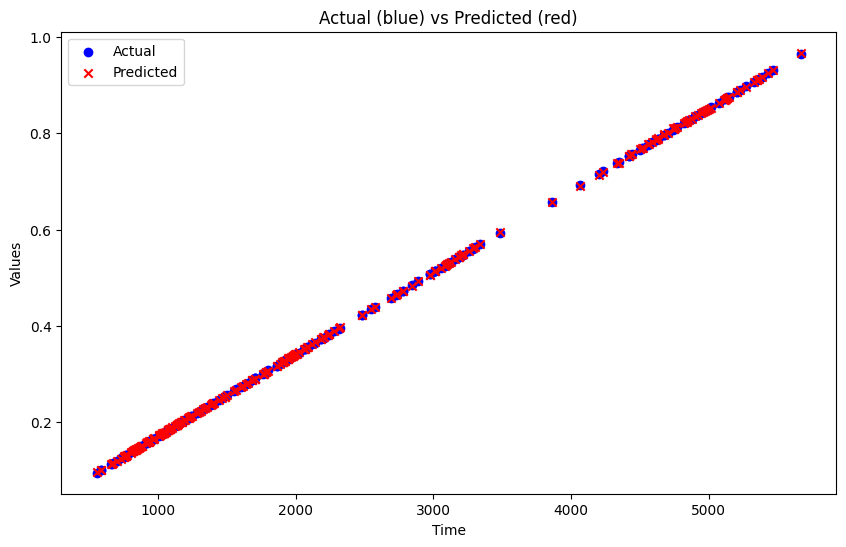

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, color='blue', marker='o', label='Actual')
plt.scatter(X_test[:, 0], y_pred, color='red', marker='x', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual (blue) vs Predicted (red)')
plt.legend()
plt.show()

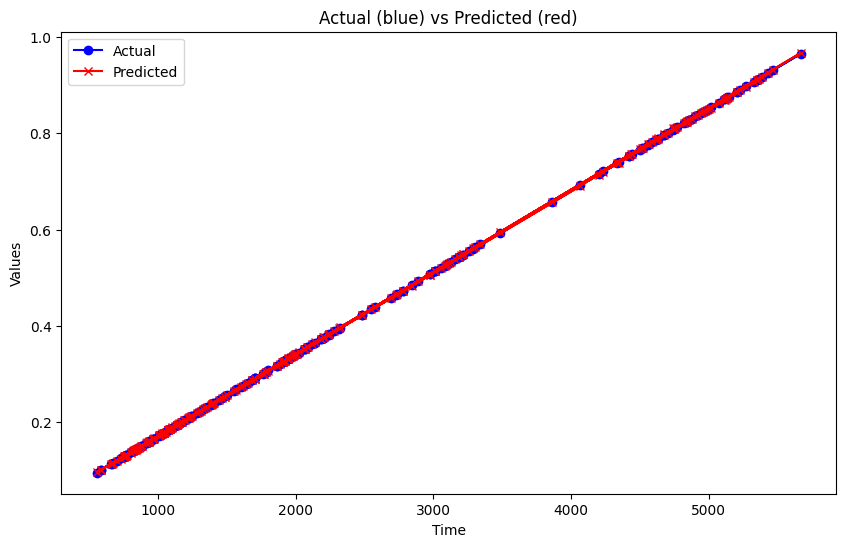

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X_test[:, 0], y_test, color='blue', marker='o', linestyle='-', label='Actual')
plt.plot(X_test[:, 0], y_pred, color='red', marker='x', linestyle='-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual (blue) vs Predicted (red)')
plt.legend()
plt.show()

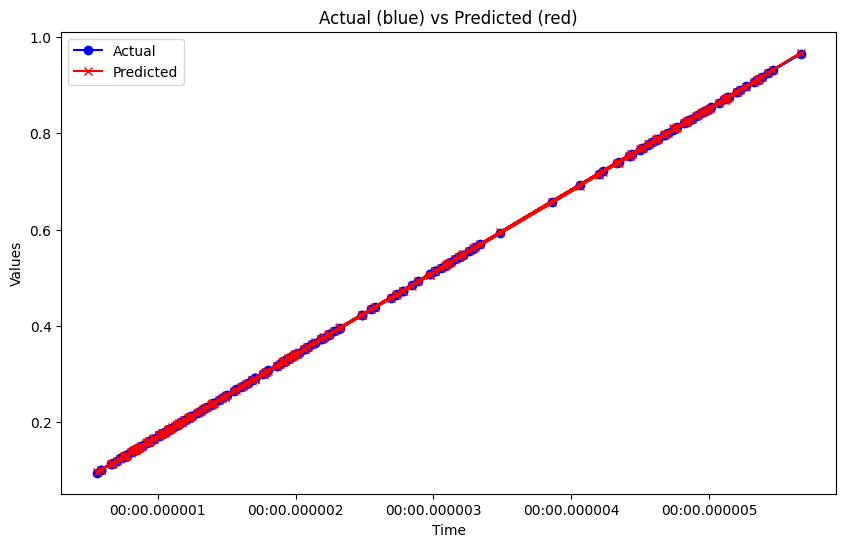

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming X_test[:, 0] contains datetime values
# If not, convert your time data to datetime format
X_test_dates = pd.to_datetime(X_test[:, 0])

plt.figure(figsize=(10, 6))
plt.plot(X_test_dates, y_test, color='blue', marker='o', linestyle='-', label='Actual')
plt.plot(X_test_dates, y_pred, color='red', marker='x', linestyle='-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual (blue) vs Predicted (red)')
plt.legend()

In [6]:
import pandas as pd

# Assuming X_test, y_test, and y_pred are already defined
# Convert X_test[:, 0] to datetime if needed
X_test_dates = pd.to_datetime(X_test[:, 0])

# Create a DataFrame
data = {
    'Time': X_test_dates,
    'Actual Values': y_test,
    'Predicted Values': y_pred
}
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_filename = '/content/rbf morning noshift.xlsx'
df.to_excel(excel_filename, index=False)
